In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json

## Plot LMP

In [2]:
res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
rundate = datetime(2024,12,1).strftime("%Y-%m-%d")
policies = ['SB', 'PF', 'MF', 'BF', 'BF8', 'BF9', 'WF', 'DR', 'DR30']
# policies = ['MF', 'BF', 'WF', 'DR']

In [11]:
from datetime import datetime
import collections
LMPS = collections.defaultdict(list)
min_LMP = collections.defaultdict(list)
time_index = []
for POLICY in policies:
    UCpath_dir = os.path.join(res_dir, rundate, POLICY, POLICY+'_'+rundate)
    if os.path.exists(UCpath_dir) == False:
        print("No such directory: ", UCpath_dir)
        continue
    if POLICY == 'SB':
        filedates = [datetime(2019,1,10).strftime("%Y-%m-%d"), datetime(2019,1,20).strftime("%Y-%m-%d"), datetime(2019,1,31).strftime("%Y-%m-%d")]
    else:
        filedates = [datetime(2019,1,31).strftime("%Y-%m-%d")] 
    for filename in filedates:
        file = os.path.join(UCpath_dir, "UC_"+filename+'.json')
        with open(file, 'r') as f:
            data = json.load(f)
            LMPS[POLICY].extend(data['Hourly average LMP'])
            if POLICY != 'SB' and len(time_index) == 0:
                time_index.extend(data['Time'])
    EDpath_dir = os.path.join(res_dir, rundate, POLICY, 'ED_'+POLICY+'_'+rundate)
    for filename in filedates:
        ed_file = os.path.join(EDpath_dir, "ED_"+filename+'.json')
        with open(ed_file, 'r') as f:
            data = json.load(f)
            for d in data['LMP']:
                min_LMP[POLICY].extend(d)

No such directory:  /Users/hanshu/Desktop/Price_formation/Result/2024-12-01/BF8/BF8_2024-12-01
No such directory:  /Users/hanshu/Desktop/Price_formation/Result/2024-12-01/BF9/BF9_2024-12-01


In [4]:
import math
min_len = min([len(LMPS[key]) for key in LMPS.keys()])
LMPS = {key: LMPS[key][:min_len] for key in LMPS.keys()}
LMP_df = pd.DataFrame(LMPS)
LMP_df.insert(0, 'Time', time_index)
LMP_df.Time = pd.to_datetime(LMP_df.Time)
print('Rundate is', rundate)
LMP_df.describe().round(2)

Rundate is 2024-12-01


,Time,SB,PF,MF,BF,WF,DR,DR30
count,744,744.00,744.00,744.00,744.00,744.00,744.00,744.00
mean,2019-01-16 11:30:00,41.92,36.38,102.61,36.23,33.36,61.82,46.10
min,2019-01-01 00:00:00,24.77,25.00,24.85,24.58,24.96,24.55,24.44
25%,2019-01-08 17:45:00,32.46,32.82,32.45,30.98,29.37,32.43,32.45
50%,2019-01-16 11:30:00,36.95,36.38,38.39,34.85,32.17,38.38,36.66
75%,2019-01-24 05:15:00,40.00,40.00,40.00,40.00,38.86,40.00,40.00
max,2019-01-31 23:00:00,2213.23,58.54,5000.00,226.12,59.56,5000.00,3201.15
std,NaN,86.00,4.14,491.68,12.21,5.09,255.51,135.70


In [24]:
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'), index_col=0)
# df.rename(index={'NR': 'MF'}, inplace=True)
totalcosts = [df.loc[p]['TotalCosts'] for p in policies]

In [ ]:
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'), index_col=0)
x = np.arange(len(policies))

fig, ax = plt.subplots(1,3, figsize=(8,5))
for i in range(3):
    if i == 0:
        ax[i].bar(x, LMP_df.mean())
        ax[i].set_ylabel('Price ($/MWh)')
        ax[i].set_title('Average LMP')
    elif i == 1:
        ax[i].bar(x, LMP_df.std(), align='center', ecolor='black', capsize=5)
        ax[i].set_ylabel('Price ($/MWh)')
        ax[i].set_title('Std of LMP')
    else:
        ax[i].bar(x, totalcosts, align='center', ecolor='black', capsize=5)
        ax[i].set_ylabel('Costs')
        ax[i].set_title('Total costs')
    ax[i].set_xticks(x)  # Centering the labels
    ax[i].set_xlabel('POLICY')
    ax[i].set_xticklabels(policies)

plt.tight_layout()
plt.show()


In [81]:
LMP_df.describe().round(2) 

,Time,SB,PF,MF,BF,WF,DR,DR30
count,744,744.00,744.00,744.00,744.00,744.00,744.00,744.00
mean,2019-01-16 11:30:00,41.92,36.38,102.61,36.23,33.36,61.82,46.10
min,2019-01-01 00:00:00,24.77,25.00,24.85,24.58,24.96,24.55,24.44
25%,2019-01-08 17:45:00,32.46,32.82,32.45,30.98,29.37,32.43,32.45
50%,2019-01-16 11:30:00,36.95,36.38,38.39,34.85,32.17,38.38,36.66
75%,2019-01-24 05:15:00,40.00,40.00,40.00,40.00,38.86,40.00,40.00
max,2019-01-31 23:00:00,2213.23,58.54,5000.00,226.12,59.56,5000.00,3201.15
std,NaN,86.00,4.14,491.68,12.21,5.09,255.51,135.70


In [12]:
min_len = min([len(min_LMP[POLICY]) for POLICY in min_LMP.keys()])
min_LMP = {POLICY : min_LMP[POLICY][:min_len] for POLICY in min_LMP.keys()}
min_time_index = pd.date_range(start='2019-01-01', periods=min_len, freq='5T')
min_LMP_df = pd.DataFrame(min_LMP, index=min_time_index)
min_LMP_df.describe().round(2)

,SB,PF,MF,BF,WF,DR,DR30
count,8928.00,8928.00,8928.00,8928.00,8928.00,8928.00,8928.00
mean,41.92,36.38,102.61,36.23,33.36,61.82,46.10
std,117.63,4.44,524.66,12.83,5.23,287.29,164.00
min,24.57,25.00,24.52,24.31,24.52,22.83,22.82
25%,32.14,32.40,32.40,30.53,28.72,32.40,32.40
50%,37.09,37.85,40.00,35.06,31.62,38.86,37.31
75%,40.00,40.00,40.00,40.00,40.00,40.00,40.00
max,5000.00,68.76,5000.00,236.21,59.56,5000.00,5000.00


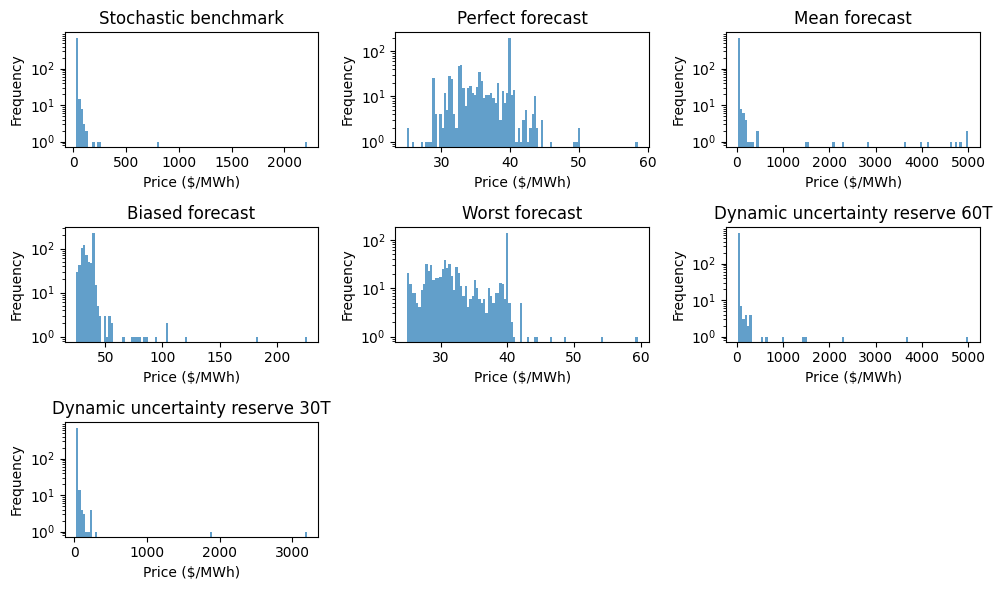

In [66]:
policy_names = {"SB": "Stochastic benchmark",
                "PF": "Perfect forecast", 
                "MF": "Mean forecast", 
                "BF":"Biased forecast", 
                "BF8":"Biased forecast p = 0.8",
                "BF9":"Biased forecast p = 0.9",
                "WF": "Worst forecast", 
                "DR":"Dynamic uncertainty reserve 60T",
                "DR30": "Dynamic uncertainty reserve 30T"}
fig, ax = plt.subplots(3,3, figsize=(10,6))
for i in range(9):
    if i < len(LMP_df.columns) - 1:
        ax[i//3, i%3].hist(LMP_df.iloc[:,i+1], bins=100, alpha=0.7)
        ax[i//3, i%3].set_title(policy_names[LMP_df.columns[i+1]])
        ax[i//3, i%3].set_xlabel("Price ($/MWh)")
        ax[i//3, i%3].set_ylabel("Frequency")
        ax[i//3, i%3].set_yscale('log')
        # ax[i//3, i%3].set_xlim(-25, 200)
        # ax[i//3, i%3].grid(True, which="both", ls="--")
    else:
        ax[i//3, i%3].axis('off')
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(res_dir, rundate, 'LMP_hist.pdf'))

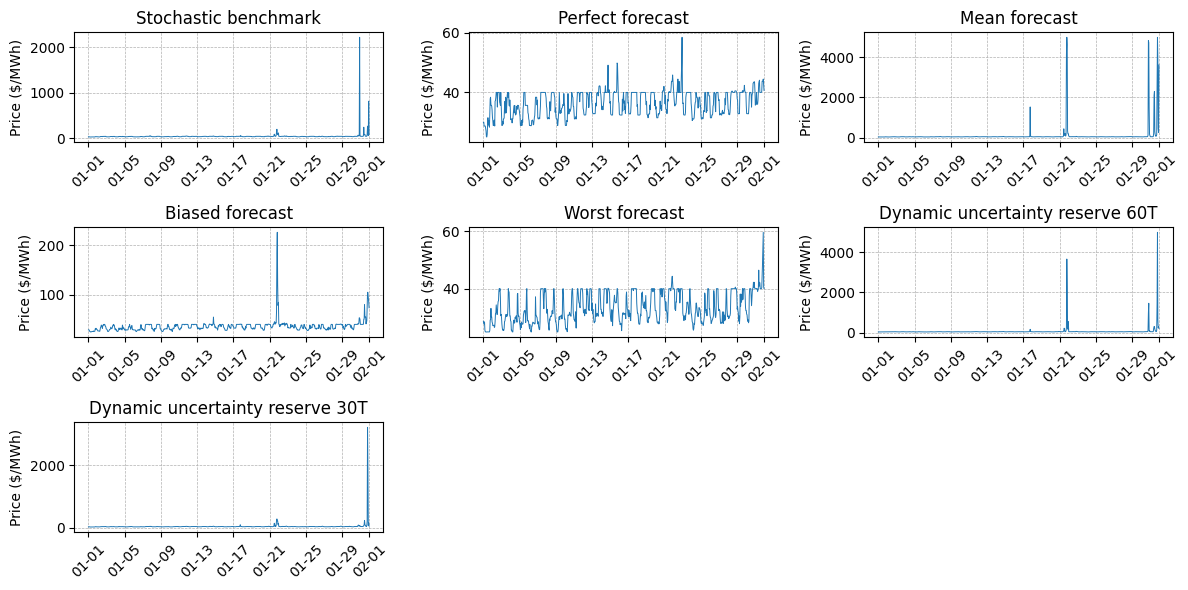

In [67]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(3,3, figsize=(12,6))
for i in range(9):
    if i < len(LMP_df.columns)-1:
        ax[i//3, i%3].plot(LMP_df.Time, LMP_df.iloc[:,i+1], linewidth=0.7)
        ax[i//3, i%3].set_title(policy_names[LMP_df.columns[i+1]])
        ax[i//3, i%3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[i//3, i%3].tick_params(axis='x', rotation=45)
        ax[i//3, i%3].set_ylabel("Price ($/MWh)")
        ax[i//3, i%3].grid(True, which='both', linestyle='--', linewidth=0.5)
    else:
        ax[i//3, i%3].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(res_dir, rundate, 'LMP_timeseries.pdf'))

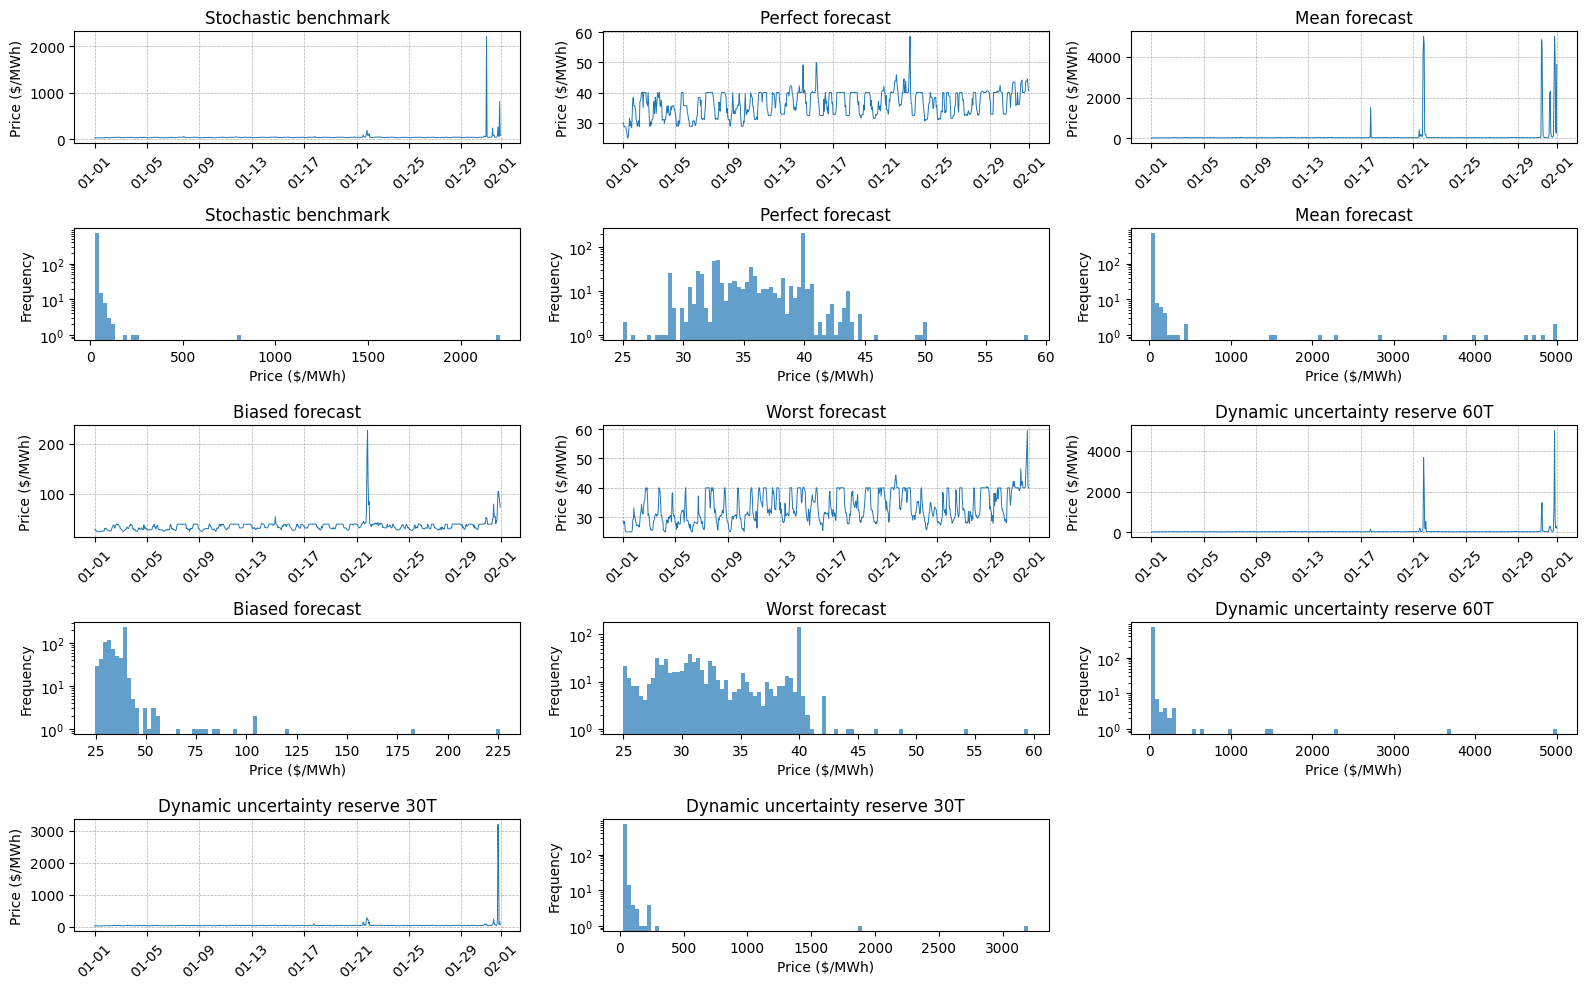

In [80]:
fig, ax = plt.subplots(5,3, figsize=(16,10))
for i in range(len(LMP_df.columns)-1):
    if i < len(LMP_df.columns)-2:
        ax[2*(i//3), i%3].plot(LMP_df.Time, LMP_df.iloc[:,i+1], linewidth=0.7)
        ax[2*(i//3), i%3].set_title(policy_names[LMP_df.columns[i+1]])
        ax[2*(i//3), i%3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[2*(i//3), i%3].tick_params(axis='x', rotation=45)
        ax[2*(i//3), i%3].set_ylabel("Price ($/MWh)")
        ax[2*(i//3), i%3].grid(True, which='both', linestyle='--', linewidth=0.5)

        ax[2*(i//3)+1, i%3].hist(LMP_df.iloc[:,i+1], bins=100, alpha=0.7)
        ax[2*(i//3)+1, i%3].set_title(policy_names[LMP_df.columns[i+1]])
        ax[2*(i//3)+1, i%3].set_xlabel("Price ($/MWh)")
        ax[2*(i//3)+1, i%3].set_ylabel("Frequency")
        ax[2*(i//3)+1, i%3].set_yscale('log')
    elif i == len(LMP_df.columns)-2:
        ax[4, i%3].plot(LMP_df.Time, LMP_df.iloc[:,i+1], linewidth=0.7)
        ax[4, i%3].set_title(policy_names[LMP_df.columns[i+1]])
        ax[4, i%3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax[4, i%3].tick_params(axis='x', rotation=45)
        ax[4, i%3].set_ylabel("Price ($/MWh)")
        ax[4, i%3].grid(True, which='both', linestyle='--', linewidth=0.5)

        ax[4, i%3+1].hist(LMP_df.iloc[:,i+1], bins=100, alpha=0.7)
        ax[4, i%3+1].set_title(policy_names[LMP_df.columns[i+1]])
        ax[4, i%3+1].set_xlabel("Price ($/MWh)")
        ax[4, i%3+1].set_ylabel("Frequency")
        ax[4, i%3+1].set_yscale('log')

ax[4, 2].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(res_dir, rundate, 'LMP_timeseries_hist.pdf'))

In [5]:
res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'))
print("Rundate is ", rundate)
df

Rundate is  2024-12-01


,POLICY,Gen_energy_revenue,Gen_reserve_revenue,Fast_gen_profits,Nuclear_profits,Storage_profits,Thermal_profits,All_gen_profits,TotalCosts,Load_curtailment,Genfuel_cost,Gen_integer_cost,Load_curtailment_penalty,Wind_gen,Solar_gen
0,SB,5.450406e+08,2.406522e+06,1.393583e+07,1.604592e+08,3.957656e+06,2.397288e+08,3.903943e+08,1.571233e+08,14.102056,1.557891e+08,1263694.47,7.051028e+04,844854.676641,47538.668938
1,PF,4.612074e+08,1.853320e+04,1.077728e+07,1.380784e+08,3.007514e+05,1.826199e+08,3.067810e+08,1.544449e+08,0.000000,1.540165e+08,428472.00,0.000000e+00,844854.676641,47538.668938
2,MF,1.460562e+09,1.026274e+07,6.042137e+07,4.056337e+08,1.937387e+07,8.980501e+08,1.316587e+09,1.706526e+08,3282.988900,1.536843e+08,553382.00,1.641494e+07,844854.676641,47538.668938
3,BF,4.655848e+08,1.003654e+05,1.101071e+07,1.374495e+08,6.709373e+05,1.826864e+08,3.077438e+08,1.579414e+08,0.000000,1.570974e+08,843979.57,0.000000e+00,844854.676641,47538.668938
4,WF,4.302217e+08,1.241081e-11,1.028693e+07,1.258718e+08,2.568383e+05,1.526193e+08,2.665325e+08,1.636892e+08,0.000000,1.622400e+08,1449144.54,0.000000e+00,844854.676641,47538.668938
5,DR,8.513754e+08,7.360854e+06,2.924740e+07,2.408325e+08,6.068873e+06,4.669393e+08,7.036321e+08,1.592536e+08,829.904297,1.543793e+08,724810.50,4.149521e+06,844854.676641,47538.668938
6,DR30,6.117362e+08,2.252812e+06,1.739155e+07,1.773393e+08,1.709541e+06,2.924629e+08,4.579284e+08,1.566068e+08,109.242811,1.550253e+08,1035247.13,5.462141e+05,844854.676641,47538.668938


In [16]:
res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'))
print("Rundate is ", rundate)
df

Rundate is  2024-12-01


,POLICY,Gen_energy_revenue,Gen_reserve_revenue,Fast_gen_profits,Nuclear_profits,Storage_profits,Thermal_profits,All_gen_profits,TotalCosts,Load_curtailment,Genfuel_cost,Gen_integer_cost,Load_curtailment_penalty,Wind_gen,Solar_gen
0,SB,5.450406e+08,2.406522e+06,1.393583e+07,1.604592e+08,3.957656e+06,2.397288e+08,3.903943e+08,1.571233e+08,14.102056,1.557891e+08,1263694.47,7.051028e+04,844854.676641,47538.668938
1,PF,4.612074e+08,1.853320e+04,1.077728e+07,1.380784e+08,3.007514e+05,1.826199e+08,3.067810e+08,1.544449e+08,0.000000,1.540165e+08,428472.00,0.000000e+00,844854.676641,47538.668938
2,MF,1.460562e+09,1.026274e+07,6.042137e+07,4.056337e+08,1.937387e+07,8.980501e+08,1.316587e+09,1.706526e+08,3282.988900,1.536843e+08,553382.00,1.641494e+07,844854.676641,47538.668938
3,BF,4.655848e+08,1.003654e+05,1.101071e+07,1.374495e+08,6.709373e+05,1.826864e+08,3.077438e+08,1.579414e+08,0.000000,1.570974e+08,843979.57,0.000000e+00,844854.676641,47538.668938
4,WF,4.302217e+08,1.241081e-11,1.028693e+07,1.258718e+08,2.568383e+05,1.526193e+08,2.665325e+08,1.636892e+08,0.000000,1.622400e+08,1449144.54,0.000000e+00,844854.676641,47538.668938
5,DR,8.513754e+08,7.360854e+06,2.924740e+07,2.408325e+08,6.068873e+06,4.669393e+08,7.036321e+08,1.592536e+08,829.904297,1.543793e+08,724810.50,4.149521e+06,844854.676641,47538.668938
6,DR30,6.117362e+08,2.252812e+06,1.739155e+07,1.773393e+08,1.709541e+06,2.924629e+08,4.579284e+08,1.566068e+08,109.242811,1.550253e+08,1035247.13,5.462141e+05,844854.676641,47538.668938


In [14]:
df['Gen_energy_revenue'] + df['Gen_reserve_revenue'] - df['Genfuel_cost'] - df['Gen_integer_cost']

0    3.903943e+08
1    3.067810e+08
2    1.316587e+09
3    3.077438e+08
4    2.665325e+08
5    7.036321e+08
6    4.579284e+08
dtype: float64

[Text(0.2, 0, 'PF'),
 Text(1.2, 0, 'MF'),
 Text(2.2, 0, 'BF'),
 Text(3.2, 0, 'WF'),
 Text(4.2, 0, 'DR'),
 Text(5.2, 0, 'DR30')]

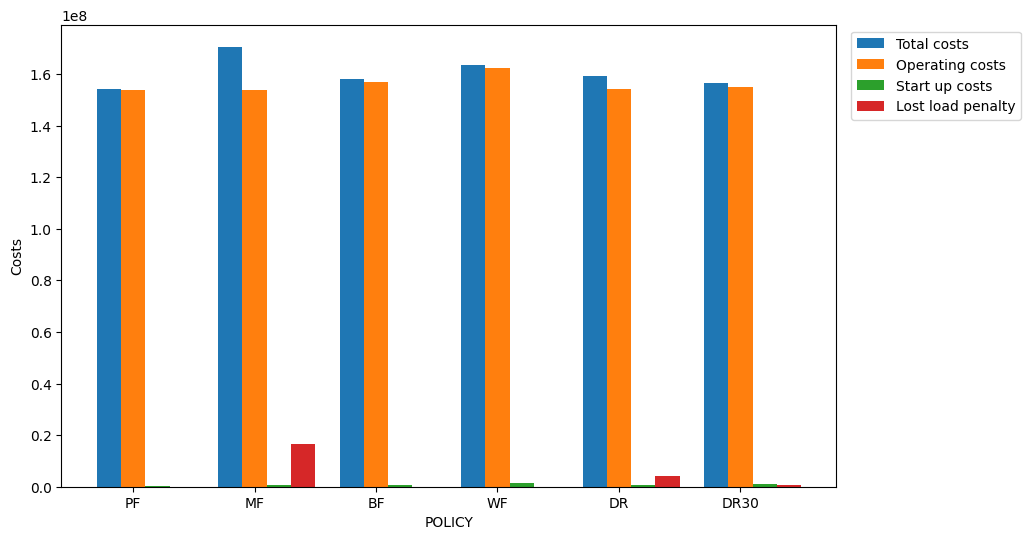

In [21]:
x = np.arange(len(df['POLICY']))
plotcols = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty']
colnames = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty']
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(4):
    ax.bar(x + i*width, df[plotcols[i]], width, label=colnames[i])
ax.set_xlabel('POLICY')
ax.set_ylabel('Costs')
# ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xticks(x + width)  # Centering the labels
ax.set_xticklabels(df['POLICY'])

In [6]:
res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
df = pd.read_csv(os.path.join(res_dir, rundate, 'revenue_cost.csv'))
print("Rundate is ", rundate)
df.iloc[5, 0] = 'DR60'
df

,POLICY,Gen_energy_revenue,Gen_reserve_revenue,Fast_gen_profits,Nuclear_profits,Storage_profits,Thermal_profits,All_gen_profits,TotalCosts,Load_curtailment,Genfuel_cost,Gen_integer_cost,Load_curtailment_penalty,Wind_gen,Solar_gen
0,SB,5.450406e+08,2.406522e+06,1.393583e+07,1.604592e+08,3.957656e+06,2.397288e+08,3.903943e+08,1.571233e+08,14.102056,1.557891e+08,1263694.47,7.051028e+04,844854.676641,47538.668938
1,PF,4.612074e+08,1.853320e+04,1.077728e+07,1.380784e+08,3.007514e+05,1.826199e+08,3.067810e+08,1.544449e+08,0.000000,1.540165e+08,428472.00,0.000000e+00,844854.676641,47538.668938
2,MF,1.460562e+09,1.026274e+07,6.042137e+07,4.056337e+08,1.937387e+07,8.980501e+08,1.316587e+09,1.706526e+08,3282.988900,1.536843e+08,553382.00,1.641494e+07,844854.676641,47538.668938
3,BF,4.655848e+08,1.003654e+05,1.101071e+07,1.374495e+08,6.709373e+05,1.826864e+08,3.077438e+08,1.579414e+08,0.000000,1.570974e+08,843979.57,0.000000e+00,844854.676641,47538.668938
4,WF,4.302217e+08,1.241081e-11,1.028693e+07,1.258718e+08,2.568383e+05,1.526193e+08,2.665325e+08,1.636892e+08,0.000000,1.622400e+08,1449144.54,0.000000e+00,844854.676641,47538.668938
5,DR60,8.513754e+08,7.360854e+06,2.924740e+07,2.408325e+08,6.068873e+06,4.669393e+08,7.036321e+08,1.592536e+08,829.904297,1.543793e+08,724810.50,4.149521e+06,844854.676641,47538.668938
6,DR30,6.117362e+08,2.252812e+06,1.739155e+07,1.773393e+08,1.709541e+06,2.924629e+08,4.579284e+08,1.566068e+08,109.242811,1.550253e+08,1035247.13,5.462141e+05,844854.676641,47538.668938


In [21]:
select = df[['POLICY', 'TotalCosts', 'Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment']]
select['TotalCosts'] = select.TotalCosts / 1e6
select['Genfuel_cost'] = select.Genfuel_cost / 1e6
select['Gen_integer_cost'] = select.Gen_integer_cost / 1e6
select.round(2)

/var/folders/r9/6nk286ys19gfq_wkhf_xf7zw0000gn/T/ipykernel_27765/608482872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select['TotalCosts'] = select.TotalCosts / 1e6
/var/folders/r9/6nk286ys19gfq_wkhf_xf7zw0000gn/T/ipykernel_27765/608482872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select['Genfuel_cost'] = select.Genfuel_cost / 1e6
/var/folders/r9/6nk286ys19gfq_wkhf_xf7zw0000gn/T/ipykernel_27765/608482872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,POLICY,TotalCosts,Genfuel_cost,Gen_integer_cost,Load_curtailment
0,SB,157.12,155.79,1.26,14.10
1,PF,154.44,154.02,0.43,0.00
2,MF,170.65,153.68,0.55,3282.99
3,BF,157.94,157.10,0.84,0.00
4,WF,163.69,162.24,1.45,0.00
5,DR60,159.25,154.38,0.72,829.90
6,DR30,156.61,155.03,1.04,109.24


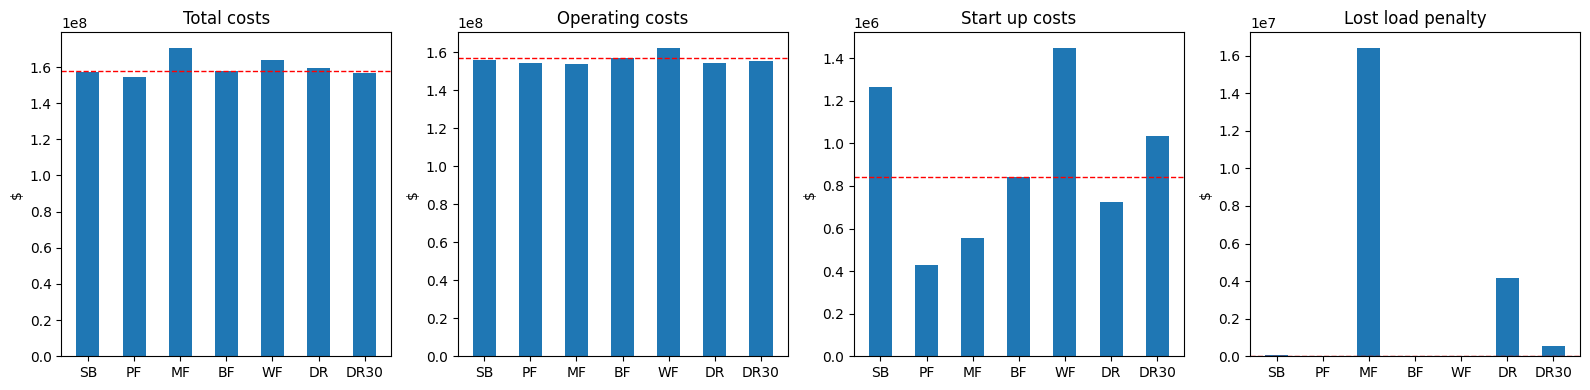

In [17]:
columns = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty', 'Gen_energy_revenue', 'Gen_reserve_revenue', 'Fast_gen_profits', 'Nuclear_profits', 'Storage_profits', 'All_gen_profits']
column_titles = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty', 'Energy revenue', 'Reserve revenue', 'Fast generators profits', 'Nuclear profits', 'Storage profits', 'Profits of all generators']
x = np.arange(len(df['POLICY']))  # Label locations for categories
width = 0.5  # Width of each bar

# Plotting the bars
fig, ax = plt.subplots(1,4,figsize=(16,4))
for i in range(4):
    ax[i].bar(df['POLICY'], [df.iloc[j][columns[i]] for j in range(len(df))], width)
    ax[i].axhline(y=df.iloc[3][columns[i]], color='red', linestyle='--', linewidth=1) #plot(, linestyle = '--', color='red', label='Base case')
    ax[i].set_ylabel('$')
    ax[i].set_xticks(x)  # Centering the labels
    ax[i].set_title(column_titles[i])
plt.tight_layout()  # Adjust layout to fit everything
plt.savefig(os.path.join(res_dir, rundate, 'costs.pdf'))

# fig, ax = plt.subplots(2,5,figsize=(18,6))
# for i in range(len(columns)):
#     ax[i//5, i%5].bar(df['POLICY'], [df.iloc[j][columns[i]] for j in range(len(df))], width)
#     ax[i//5, i%5].axhline(y=df.iloc[3][columns[i]], color='red', linestyle='--', linewidth=1) #plot(, linestyle = '--', color='red', label='Base case')
#     ax[i//5, i%5].set_ylabel('$')
#     ax[i//5, i%5].set_xticks(x)  # Centering the labels
#     ax[i//5, i%5].set_title(column_titles[i])
# plt.tight_layout()  # Adjust layout to fit everything
# # plt.show()
# plt.savefig(os.path.join(res_dir, rundate, 'revenue_cost.svg'))

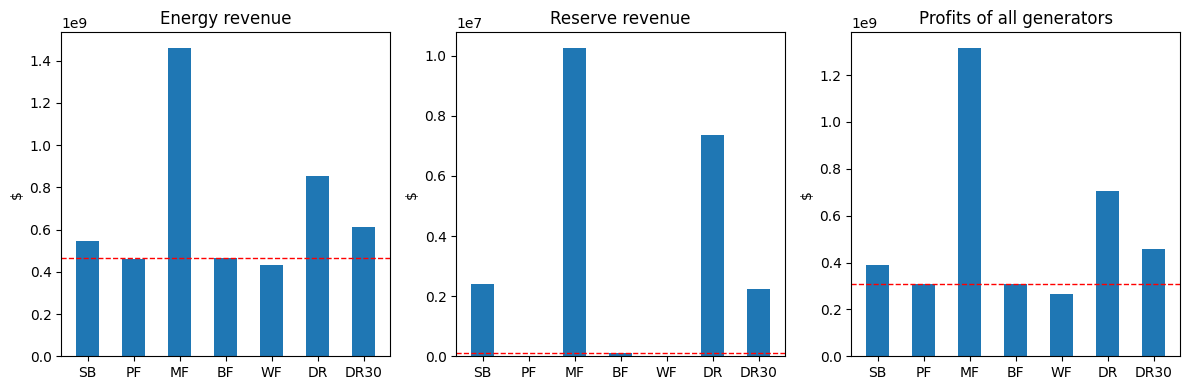

In [18]:
fig, ax = plt.subplots(1, 3,figsize=(12,4))
k = [4,5,9]
for i in range(3):
    ax[i].bar(df['POLICY'], [df.iloc[j][columns[k[i]]] for j in range(len(df))], width)
    ax[i].axhline(y=df.iloc[3][columns[k[i]]], color='red', linestyle='--', linewidth=1) #plot(, linestyle = '--', color='red', label='Base case')
    ax[i].set_ylabel('$')
    ax[i].set_xticks(x)  # Centering the labels
    ax[i].set_title(column_titles[k[i]])
plt.tight_layout()  # Adjust layout to fit everything
# plt.show()
plt.savefig(os.path.join(res_dir, rundate, 'revenues.pdf'))

In [5]:
res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
rundate = datetime(2024,12,1).strftime("%Y-%m-%d")
perunint_df = pd.read_csv(os.path.join(res_dir, rundate, 'PerUnitProfit.csv'))
perunint_df.iloc[5, 0] = 'DR60'
print("Rundate is ", rundate)
perunint_df.round(1)

Rundate is  2024-12-01


,POLICY,Fast,Nuclear,Thermal,BA,PH,wind,solar,hydro
0,SB,4532.4,29550.5,7377.6,541.1,2688.8,11667.1,2392.3,22265.8
1,PF,3505.1,25428.8,5620.1,104.7,122.8,9376.1,2266.8,19078.0
2,MF,19651.1,74702.3,27637.2,3216.6,12435.1,34722.4,4850.0,58840.8
3,BF,3581.1,25313.0,5622.1,250.8,251.9,9503.1,2243.7,19105.5
4,WF,3345.7,23180.8,4696.8,125.2,59.0,8599.5,2093.7,17506.9
5,DR60,9512.3,44352.2,14369.9,1707.5,2998.0,19115.4,2817.5,34634.3
6,DR30,5656.3,32659.2,9000.5,522.8,790.9,13070.6,2545.1,24841.8


In [3]:
def calc_perunit_percentage_df(res_dir, rundate, ref_policy):
    print('Referece policy is', ref_policy)
    perunint_df = pd.read_csv(os.path.join(res_dir, rundate, 'PerUnitProfit.csv'))
    perunint_df.iloc[5, 0] = 'DR60'
    df = perunint_df.T
    df.columns = df.iloc[0]  # Assign the first row to column names
    df = df[1:]  # Remove the first row
    percentage_df = pd.DataFrame()
    for i in range(len(df.columns)):
        if df.columns[i] != ref_policy:
            percentage_df[df.columns[i]] = (df.iloc[:,i]) / df[ref_policy] * 100
    percentage_df = percentage_df.apply(pd.to_numeric, errors='coerce').round(1)
    return percentage_df

res_dir = "/Users/hanshu/Desktop/Price_formation/Result"
rundate = datetime(2024,12,1).strftime("%Y-%m-%d")
BF_percentage_df = calc_perunit_percentage_df(res_dir, rundate, 'BF')
SB_percentage_df = calc_perunit_percentage_df(res_dir, rundate, 'SB')

Referece policy is BF
Referece policy is SB


In [4]:
perunint_df = pd.read_csv(os.path.join(res_dir, rundate, 'PerUnitProfit.csv'))
perunint_df.iloc[5, 0] = 'DR60'
df = perunint_df.T
df.columns = df.iloc[0]  # Assign the first row to column names
df = df[1:]  # Remove the first row
diff_df = pd.DataFrame()
for i in range(len(df.columns)):
    diff_df[df.columns[i]] = (df.iloc[:,i] - df['BF']) * 365 / (1000*31)
    diff_df = diff_df.apply(pd.to_numeric, errors='coerce').round(1)
diff_df

,SB,PF,MF,BF,WF,DR60,DR30
Fast,53.4,41.3,231.4,42.2,39.4,112.0,66.6
Nuclear,347.9,299.4,879.6,298.0,272.9,522.2,384.5
Thermal,86.9,66.2,325.4,66.2,55.3,169.2,106.0
BA,6.4,1.2,37.9,3.0,1.5,20.1,6.2
PH,31.7,1.4,146.4,3.0,0.7,35.3,9.3
wind,137.4,110.4,408.8,111.9,101.3,225.1,153.9
solar,28.2,26.7,57.1,26.4,24.7,33.2,30.0
hydro,262.2,224.6,692.8,225.0,206.1,407.8,292.5


In [50]:
perunint_df = pd.read_csv(os.path.join(res_dir, rundate, 'PerUnitProfit.csv'))
perunint_df.iloc[5, 0] = 'DR60'
df = perunint_df.T
df.columns = df.iloc[0]  # Assign the first row to column names
df = df[1:]  # Remove the first row
CONE = 130.63
ELCC = {'Fast':1.0, 'Nuclear':1.0, 'Thermal':1.0, 'BA':0.64, 'PH':1.0, 'wind':0.13, 'solar':0.15, 'hydro':1.0}
profits_df = pd.DataFrame()
for i in range(len(df.columns)):
    profits_df[df.columns[i]] = (df.iloc[:,i]) * 365 / (1000*31)
#     Cap_revenue = max(0, CONE - profits_df.iloc[0, i])
#     # adjust Cap_reveue for each column
#     for j in range(len(profits_df)):
#         profits_df.iloc[j, i] += Cap_revenue * ELCC[profits_df.index[j]]
profits_df = profits_df.apply(pd.to_numeric, errors='coerce').round(1)

EAS_relative_df = pd.DataFrame()
for i in range(len(profits_df.columns)):
    if profits_df.columns[i] != 'BF':
        EAS_relative_df[profits_df.columns[i]] = profits_df.iloc[:,i] - profits_df['BF']
EAS_relative_df = EAS_relative_df.apply(pd.to_numeric, errors='coerce').round(1)
EAS_relative_df.T

# relativeBF_df = pd.DataFrame()
# for i in range(len(profits_df.columns)):
#     if profits_df.columns[i] != 'BF':
#         relativeBF_df[profits_df.columns[i]] = (profits_df.iloc[:,i]) / profits_df['BF'] * 100
# relativeBF_df.T.round(1)

,Fast,Nuclear,Thermal,BA,PH,wind,solar,hydro
SB,11.2,49.9,20.7,3.4,28.7,25.5,1.8,37.2
PF,-0.9,1.4,0.0,-1.8,-1.6,-1.5,0.3,-0.4
MF,189.2,581.6,259.2,34.9,143.4,296.9,30.7,467.8
WF,-2.8,-25.1,-10.9,-1.5,-2.3,-10.6,-1.7,-18.9
DR60,69.8,224.2,103.0,17.1,32.3,113.2,6.8,182.8
DR30,24.4,86.5,39.8,3.2,6.3,42.0,3.6,67.5


In [46]:
profits_df.T

,Fast,Nuclear,Thermal,BA,PH,wind,solar,hydro
SB,130.6,425.2,164.1,55.8,108.9,147.4,39.8,339.4
PF,130.6,388.8,155.5,58.4,90.8,122.0,40.1,314.0
MF,231.4,879.6,325.4,37.9,146.4,408.8,57.1,692.8
BF,130.6,386.5,154.7,59.6,91.4,123.4,39.7,313.4
WF,130.6,364.2,146.5,59.9,91.9,113.1,38.3,297.4
DR60,130.6,540.8,187.8,32.0,53.9,227.5,36.0,426.4
DR30,130.6,448.6,170.0,47.1,73.3,162.2,39.6,356.5


In [33]:
diff_df = pd.DataFrame()
for i in range(len(df.columns)):
    diff_df[df.columns[i]] = profits_df.iloc[:,i] - profits_df['BF']
    diff_df = diff_df.apply(pd.to_numeric, errors='coerce').round(1)
diff_df

,SB,PF,MF,BF,WF,DR60,DR30
Fast,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nuclear,38.7,2.3,392.3,0.0,-22.3,154.3,62.1
Thermal,9.4,0.8,70.0,0.0,-8.2,33.1,15.3
BA,-3.8,-1.2,-86.2,0.0,0.3,-27.6,-12.5
PH,17.5,-0.6,-45.7,0.0,0.5,-37.5,-18.1
wind,24.0,-1.4,272.3,0.0,-10.3,104.1,38.8
solar,0.1,0.4,2.3,0.0,-1.4,-3.7,-0.1
hydro,26.0,0.6,278.7,0.0,-16.0,113.0,43.1


In [41]:
ELCC = {'Fast':1.0, 'Nuclear':1.0, 'Thermal':1.0, 'BA':0.64, 'PH':1.0, 'wind':0.13, 'solar':0.15, 'hydro':1.0}
for i in range(1, len(diff_df)):
    diff_df.iloc[i, :] = diff_df.iloc[i, :] - ELCC[diff_df.index[i]] * diff_df.iloc[0, :]
diff_df.insert(0, 'ELCC', ELCC)
diff_df = diff_df.apply(pd.to_numeric, errors='coerce').round(1)
diff_df

,ELCC,SB,PF,MF,BF,WF,DR60,DR30
Fast,1.0,11.2,-0.9,189.2,0.0,-2.8,69.8,24.4
Nuclear,1.0,38.7,2.3,392.3,0.0,-22.3,154.4,62.1
Thermal,1.0,9.5,0.9,70.0,0.0,-8.1,33.2,15.4
BA,0.6,-3.8,-1.1,-86.2,0.0,0.3,-27.5,-12.4
PH,1.0,17.5,-0.6,-45.8,0.0,0.5,-37.5,-18.1
wind,0.1,24.0,-1.4,272.3,0.0,-10.2,104.1,38.8
solar,0.2,0.0,0.4,2.3,0.0,-1.4,-3.7,-0.2
hydro,1.0,26.0,0.6,278.7,0.0,-16.0,113.0,43.1


In [65]:
SB_percentage_df.T

,Fast,Nuclear,Thermal,BA,PH,wind,solar,hydro
PF,77.3,86.1,76.2,19.4,4.6,80.4,94.8,85.7
MF,433.6,252.8,374.6,594.4,462.5,297.6,202.7,264.3
BF,79.0,85.7,76.2,46.3,9.4,81.5,93.8,85.8
WF,73.8,78.4,63.7,23.1,2.2,73.7,87.5,78.6
DR60,209.9,150.1,194.8,315.5,111.5,163.8,117.8,155.5
DR30,124.8,110.5,122.0,96.6,29.4,112.0,106.4,111.6


In [63]:
optimal_storage_df = pd.read_csv(os.path.join(res_dir, rundate, 'storage_profit.csv'))
storage_df = perunint_df[['POLICY', 'BA', 'PH']]
storage_df.loc[:, 'BA'] = storage_df['BA'] * 1500
storage_df.loc[:, 'PH'] = storage_df['PH'] * 1170
# storage_df divide optimal_storage_df to get the ratio
ratio_df = storage_df.copy()
ratio_df.loc[:, 'BA'] = storage_df['BA'] / optimal_storage_df['BA']
ratio_df.loc[:, 'PH'] = storage_df['PH'] / optimal_storage_df['PH']

In [64]:
ratio_df

,POLICY,BA,PH
0,SB,0.158593,0.636077
1,PF,0.376757,0.537237
2,MF,0.068199,0.257728
3,BF,0.226957,0.245822
4,WF,0.223982,0.250250
5,DR,0.096894,0.164213
6,DR30,0.075118,0.112441


In [65]:
optimal_storage_df

,POLICY,BA,PH
0,SB,6.540806e+06,5.038611e+06
1,PF,4.169477e+05,2.674114e+05
2,MF,7.074687e+07,5.645112e+07
3,BF,1.657438e+06,1.199123e+06
4,WF,8.382811e+05,2.760366e+05
5,DR,2.643303e+07,2.136041e+07
6,DR30,1.043922e+07,8.229851e+06


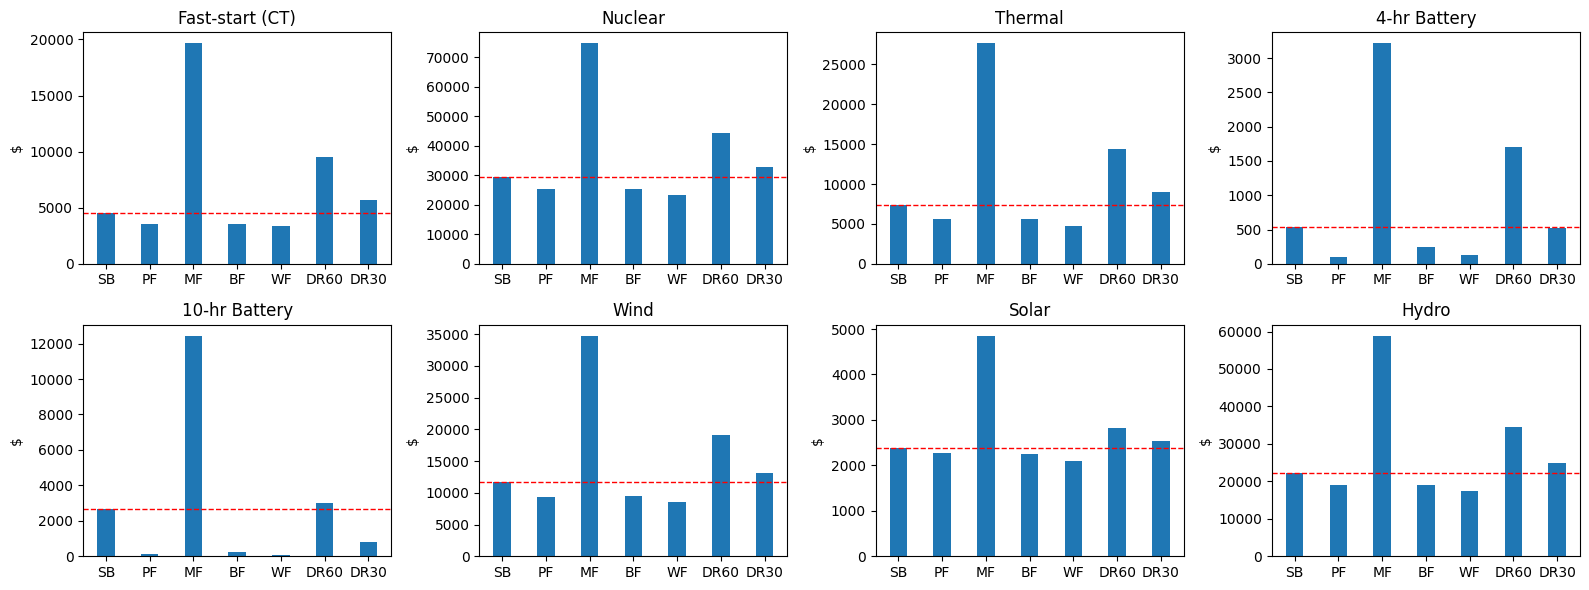

In [21]:
s = {'Fast': 'Fast-start (CT)', 'Thermal':'Thermal', 'Nuclear': 'Nuclear', 'hydro': 'Hydro', 'BA': '4-hr Battery', 'PH': '10-hr Battery', 'wind': 'Wind', 'solar': 'Solar'}
x = np.arange(len(perunint_df['POLICY']))  # Label locations for categories
width = 0.4  # Width of each bar

# Plotting the bars
fig, ax = plt.subplots(2,4,figsize=(16,6))
for i in range(len(perunint_df.columns)-1):
    ax[i//4, i%4].bar(perunint_df['POLICY'], perunint_df.iloc[:,i+1], width)
    ax[i//4, i%4].axhline(y=perunint_df.iloc[0][i+1], color='red', linestyle='--', linewidth=1) #plot(, linestyle = '--', color='red', label='Base case')
    ax[i//4, i%4].set_ylabel('$')
    ax[i//4, i%4].set_xticks(x)  # Centering the labels
    ax[i//4, i%4].set_title(s[perunint_df.columns[i+1]])
plt.tight_layout()  # Adjust layout to fit everything
plt.savefig(os.path.join(res_dir, rundate, 'perunit_profit.pdf'))

Text(0.5, 1.0, 'Per unit profits of BA and PH')

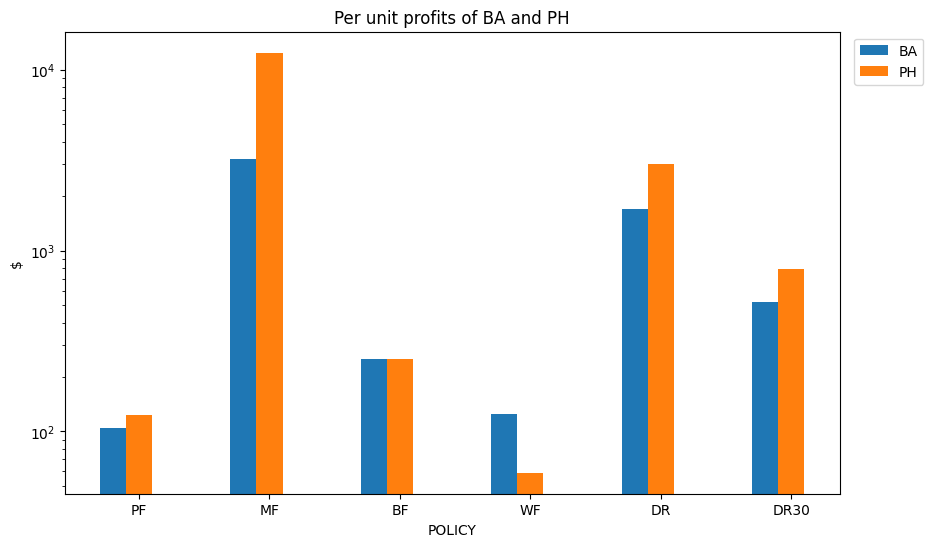

In [34]:
# Compare profits of BA and PH 
x = np.arange(len(df['POLICY']))
plotcols = ['TotalCosts','Genfuel_cost', 'Gen_integer_cost', 'Load_curtailment_penalty']
colnames = ['Total costs','Operating costs', 'Start up costs', 'Lost load penalty']
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(2):
    ax.bar(x + i*width, perunint_df.iloc[:,4+i], width, label = perunint_df.columns[4+i])
ax.set_xlabel('POLICY')
ax.set_ylabel('$')
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xticks(x + width)  # Centering the labels
ax.set_xticklabels(df['POLICY'])
ax.set_title('Per unit profits of BA and PH')

In [17]:
hydro_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/NYGrid/hydro_2019.csv')
print("The maximum hydro generation is: ", hydro_df.Gen_MW.max())
wind_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/ARPAE_NYISO/Clean_CSV/Hour/wind_actuals_2019_hourly_BA.csv')
print("The maximum wind generation is: ", wind_df.BA_total.max())
solar_df = pd.read_csv('/Users/hanshu/Desktop/Price_formation/Data/ARPAE_NYISO/Clean_CSV/Hour/solar_actuals_2019_hourly_BA.csv')
print("The maximum solar generation is: ", solar_df.BA_total.max())

The maximum hydro generation is:  4738.0
The maximum wind generation is:  1798.6622698166666
The maximum solar generation is:  448.9000012899999


In [61]:
solar_df.describe().round(2)
wind_df.describe().round(2)

,hour,BA_total
count,8760.00,8760.00
mean,11.50,88.89
std,6.92,126.62
min,0.00,0.00
25%,5.75,0.00
50%,11.50,2.23
75%,17.25,161.53
max,23.00,448.90
